In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve


def plot(image):
    plt.figure()
    plt.imshow(image.reshape((32, 32))
               if image.shape[0] != 32 else image, cmap="gray")
    plt.show()


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation="none", cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    # return fig


# Get data

In [2]:
import keras.datasets.cifar10 as cifar10

(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

# Transform data into array from 1-col matrix
ytrain = ytrain.squeeze()
ytest = ytest.squeeze()

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


# Randomize train data and sort test data

In [3]:
idx = rnd.permutation(Xtrain.shape[0])
Xtrain = Xtrain[idx]
ytrain = ytrain[idx]

idx = np.argsort(ytest)
Xtest = Xtest[idx]
ytest = ytest[idx]


# Convert images to grayscale
We're converting the images to grayscale to improve the performance of the classification. We're expecting that the performance is worse than with colored images because there are some images that would be easier to classify according to color. For example, we would expect the model to identify the blue around the ship or the plane to better distiguish them from the others

In [4]:
from skimage import color

XtrainG = np.zeros((Xtrain.shape[0], 32, 32))
for i in range(Xtrain.shape[0]):
    XtrainG[i] = color.rgb2gray(Xtrain[i])

XtestG = np.zeros((Xtest.shape[0], 32, 32))
for i in range(Xtest.shape[0]):
    XtestG[i] = color.rgb2gray(Xtest[i])


# Convert images to vectors

In [5]:
XtrainG = XtrainG.reshape((XtrainG.shape[0], XtrainG.shape[1] ** 2)) * 1.0
XtestG = XtestG.reshape((XtestG.shape[0], XtestG.shape[1] ** 2)) * 1.0

print(XtrainG.shape, ytrain.shape)
print(XtestG.shape, ytest.shape)


(50000, 1024) (50000,)
(10000, 1024) (10000,)


# Normalization

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(XtrainG)
XtrainGS = ss.transform(XtrainG)
XtestGS = ss.transform(XtestG)


# Binarize for ship (index 8)

In [7]:
ytrainB = (ytrain == 8) * 1
ytestB = (ytest == 8) * 1


#### Change names

In [8]:
X1 = XtrainG
X1s = XtrainGS
y1 = ytrain
y1b = ytrainB
X2 = XtestG
X2s = XtestGS
y2 = ytest
y2b = ytestB


# Binary classification

## SGDClassifier

In [9]:
from sklearn.linear_model import SGDClassifier


### Not normalized data

Score: 0.9
Number of errors: 1000
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9000
           1       0.00      0.00      0.00      1000

    accuracy                           0.90     10000
   macro avg       0.45      0.50      0.47     10000
weighted avg       0.81      0.90      0.85     10000



C:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

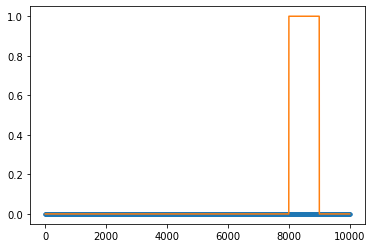

Prediction
[[9000    0]
 [1000    0]]


In [10]:
sgdb = SGDClassifier().fit(X1, y1b)
y2e = sgdb.predict(X2)

print('Score:', sgdb.score(X2, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

We moved the threshold so that it can hit the optimal point were the FP-rate is low and the TP-rate is high

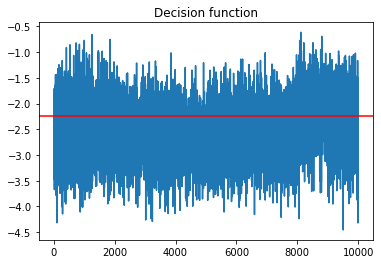

Decision function with threshold = -2.25
[[6329 2671]
 [ 354  646]]


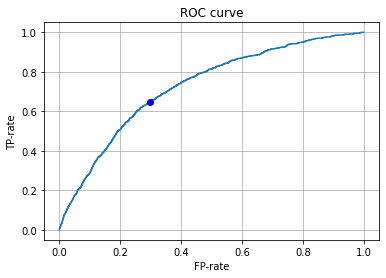

In [14]:
th = -2.25
y2d = sgdb.decision_function(X2)

plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


### Normalized data

Score: 0.8945
Number of errors: 1055
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9000
           1       0.22      0.02      0.04      1000

    accuracy                           0.89     10000
   macro avg       0.56      0.51      0.49     10000
weighted avg       0.83      0.89      0.85     10000



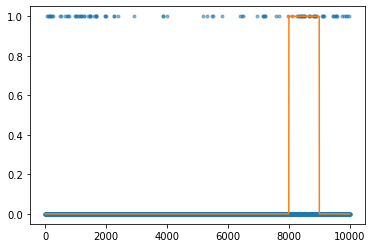

Prediction
[[8924   76]
 [ 979   21]]


In [15]:
sgdbn = SGDClassifier().fit(X1s, y1b)
y2e = sgdbn.predict(X2s)

print('Score:', sgdbn.score(X2s, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

In [1]:
th = -2
y2d = sgdbn.decision_function(X2)

plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


NameError: name 'sgdbn' is not defined

We can see that without any normalization, the classifier doesn't guess any image as ship, resulting in a score of 0.9 because every other class isn't a ship.
With normalization, the classifier was able to guess some of the images as ship, despite getting a bit more errors

## RandomForestClassifier

In [17]:
from sklearn.ensemble import RandomForestClassifier


### Not normalized data

Score: 0.912
Number of errors: 880
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9000
           1       0.78      0.17      0.28      1000

    accuracy                           0.91     10000
   macro avg       0.85      0.58      0.61     10000
weighted avg       0.90      0.91      0.89     10000



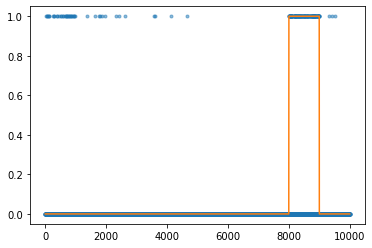

Prediction
[[8952   48]
 [ 832  168]]


In [18]:
rfcb = RandomForestClassifier().fit(X1, y1b)
y2e = rfcb.predict(X2)

print('Score:', rfcb.score(X2, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

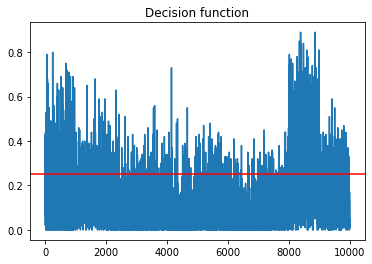

Decision function with threshold = 0.25
[[8196  804]
 [ 415  585]]


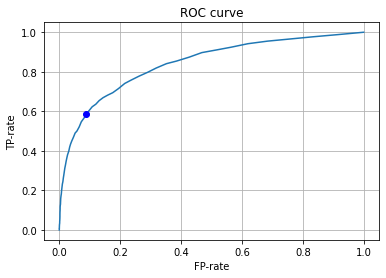

In [19]:
th = 0.25
y2d = rfcb.predict_proba(X2)[:, 1]

plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


### Normalized data

Score: 0.9118
Number of errors: 882
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9000
           1       0.75      0.18      0.29      1000

    accuracy                           0.91     10000
   macro avg       0.83      0.59      0.62     10000
weighted avg       0.90      0.91      0.89     10000



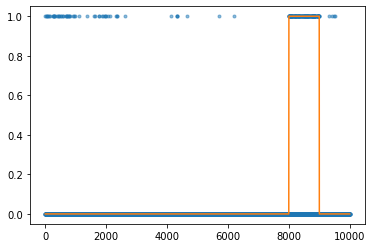

Prediction
[[8940   60]
 [ 822  178]]


In [20]:
rfcbn = RandomForestClassifier().fit(X1s, y1b)
y2e = rfcbn.predict(X2s)

print('Score:', rfcbn.score(X2s, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

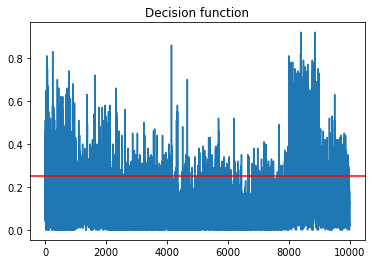

Decision function with threshold = 0.25
[[8231  769]
 [ 431  569]]


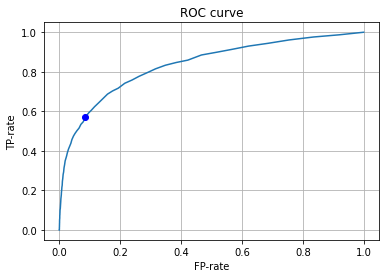

In [21]:
th = 0.25
y2d = rfcbn.predict_proba(X2s)[:, 1]

plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


In terms of normalization, we don't see too much of a difference

Comparing the two classifiers, we see that the RandomForestClassifier performs better than the SGDClassifier. It takes way longer to fit the data so it's possible that's the reason why it's better. We could have changed the hyperparameters to try to improve the performance of each one

# Multi-class classification

We decided to use the SGDClassifier because it takes a significant less amount of time to train comparing to the RandomForestClassifier

### Not normalized data

Score: 0.2047
Number of errors: 7953
              precision    recall  f1-score   support

           0       0.25      0.23      0.24      1000
           1       0.55      0.09      0.16      1000
           2       0.18      0.14      0.15      1000
           3       0.38      0.02      0.04      1000
           4       0.15      0.12      0.13      1000
           5       0.45      0.05      0.09      1000
           6       0.31      0.04      0.08      1000
           7       0.14      0.53      0.22      1000
           8       0.34      0.14      0.20      1000
           9       0.23      0.69      0.35      1000

    accuracy                           0.20     10000
   macro avg       0.30      0.20      0.17     10000
weighted avg       0.30      0.20      0.17     10000



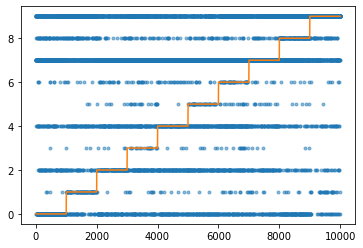

Prediction
Confusion matrix, without normalization


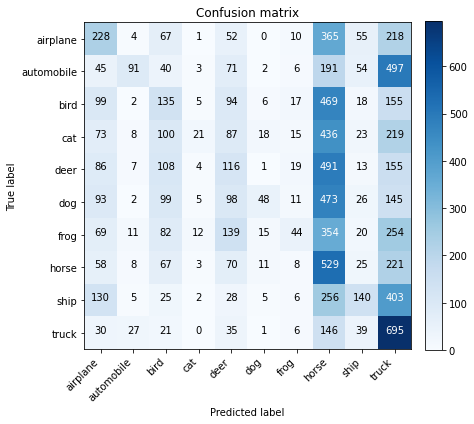

In [22]:
sgd = SGDClassifier().fit(X1, y1)
y2e = sgd.predict(X2)

print('Score:', sgd.score(X2, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


### Normalized data

Score: 0.2003
Number of errors: 7997
              precision    recall  f1-score   support

           0       0.10      0.04      0.06      1000
           1       0.23      0.34      0.27      1000
           2       0.17      0.16      0.16      1000
           3       0.12      0.12      0.12      1000
           4       0.11      0.13      0.12      1000
           5       0.17      0.21      0.19      1000
           6       0.17      0.15      0.16      1000
           7       0.23      0.15      0.18      1000
           8       0.27      0.38      0.32      1000
           9       0.39      0.32      0.35      1000

    accuracy                           0.20     10000
   macro avg       0.20      0.20      0.19     10000
weighted avg       0.20      0.20      0.19     10000



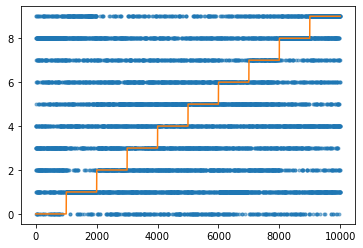

Prediction
Confusion matrix, without normalization


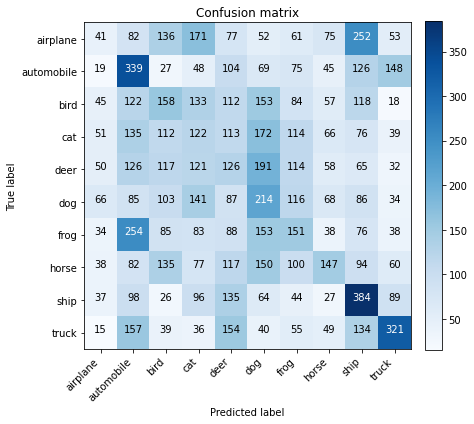

In [23]:
sgdn = SGDClassifier().fit(X1s, y1)
y2e = sgdn.predict(X2s)

print('Score:', sgdn.score(X2s, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


We can see that in the multi-class classification, the classifier performed better with the data normalized

### Validation
We'll use only the train data to estimate the performance of the classifier and compare. We'll be using the normalized data because of the better performance
We could use the KFold strategy to do the same but we decided to just split the training data and working with that as if it was the train and test data provided

In [24]:
from sklearn.model_selection import train_test_split


Score: 0.2185
Number of errors: 7815
              precision    recall  f1-score   support

           0       0.21      0.32      0.25      1000
           1       0.29      0.31      0.30      1000
           2       0.15      0.12      0.13      1000
           3       0.14      0.08      0.10      1000
           4       0.17      0.35      0.23      1000
           5       0.22      0.15      0.18      1000
           6       0.13      0.09      0.11      1000
           7       0.23      0.12      0.15      1000
           8       0.26      0.23      0.25      1000
           9       0.34      0.41      0.37      1000

    accuracy                           0.22     10000
   macro avg       0.22      0.22      0.21     10000
weighted avg       0.22      0.22      0.21     10000



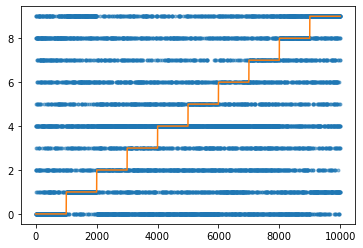

Prediction
Confusion matrix, without normalization


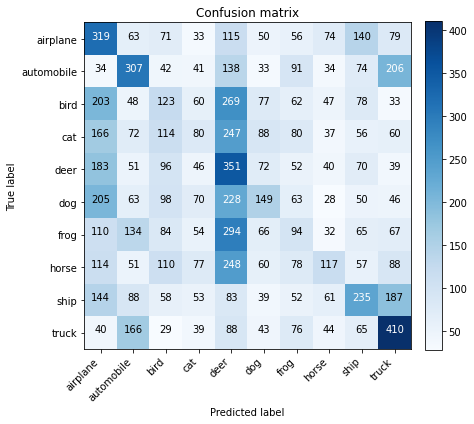

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X1s, y1, stratify=y1, test_size=0.2)

# Randomize new train data
idx = rnd.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]

# Order new test data
idx = np.argsort(y_test)
X_test = X_test[idx]
y_test = y_test[idx]

sgdn = SGDClassifier().fit(X_train, y_train)
y_test_e = sgdn.predict(X_test)

print('Score:', sgdn.score(X_test, y_test))
print("Number of errors:", np.sum(y_test != y_test_e))
print(classification_report(y_test, y_test_e))

plt.figure()
plt.plot(y_test_e, ".", alpha=0.5)
plt.plot(y_test)
plt.show()

print('Prediction')
cm = confusion_matrix(y_test, y_test_e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


## PCA
The images are in grayscale and are already with a low resolution. We're expecting that the PCA will impact the classification because the images already have low information and reducing the dimensionality will worsen the performance

In [26]:
from sklearn.decomposition import PCA


### Not normalized data

Best n_components: 200
Score: 0.225
Number of errors: 7750
              precision    recall  f1-score   support

           0       0.14      0.03      0.04      1000
           1       0.33      0.28      0.30      1000
           2       0.20      0.08      0.12      1000
           3       0.17      0.08      0.10      1000
           4       0.17      0.54      0.26      1000
           5       0.22      0.14      0.17      1000
           6       0.21      0.10      0.14      1000
           7       0.24      0.29      0.26      1000
           8       0.24      0.48      0.32      1000
           9       0.37      0.22      0.28      1000

    accuracy                           0.23     10000
   macro avg       0.23      0.23      0.20     10000
weighted avg       0.23      0.23      0.20     10000



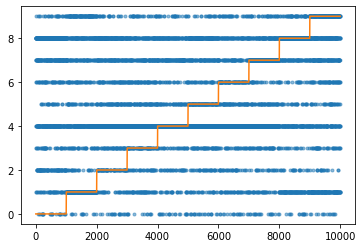

Prediction
Confusion matrix, without normalization


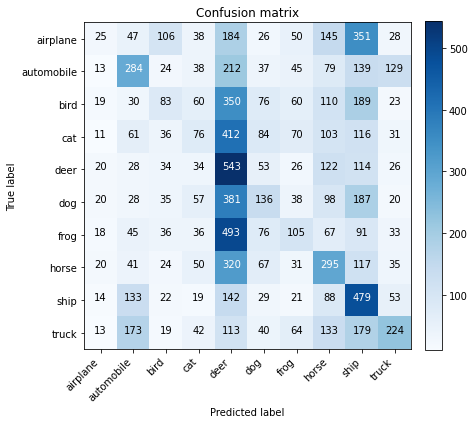

In [27]:
n_components = np.arange(100, 301, 50)
best_score = 0
best_n = 0
best_sgd = None
best_pca = None

for n in n_components:
    pca = PCA(n_components=n).fit(X1)
    X1p = pca.transform(X1)
    X2p = pca.transform(X2)

    sgd = SGDClassifier().fit(X1p, y1)
    y2e = sgd.predict(X2p)

    score = sgd.score(X2p, y2)

    if score > best_score:
        best_score = score
        best_n = n
        best_sgd = sgd
        best_pca = pca

print('Best n_components:', best_n)

sgd = best_sgd
pca = best_pca

# pca = PCA(n_components=best_n).fit(X1)
X1p = pca.transform(X1)
X2p = pca.transform(X2)

# sgd = SGDClassifier().fit(X1p, y1)
y2e = sgd.predict(X2p)

print('Score:', sgd.score(X2p, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


### Normalized data

Best n_components: 200
Score: 0.2064
Number of errors: 7936
              precision    recall  f1-score   support

           0       0.21      0.21      0.21      1000
           1       0.33      0.26      0.29      1000
           2       0.13      0.13      0.13      1000
           3       0.12      0.07      0.09      1000
           4       0.11      0.05      0.07      1000
           5       0.17      0.20      0.18      1000
           6       0.15      0.13      0.14      1000
           7       0.22      0.24      0.23      1000
           8       0.22      0.47      0.30      1000
           9       0.33      0.30      0.31      1000

    accuracy                           0.21     10000
   macro avg       0.20      0.21      0.20     10000
weighted avg       0.20      0.21      0.20     10000



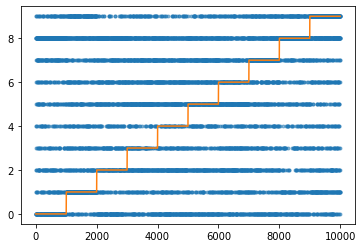

Prediction
Confusion matrix, without normalization


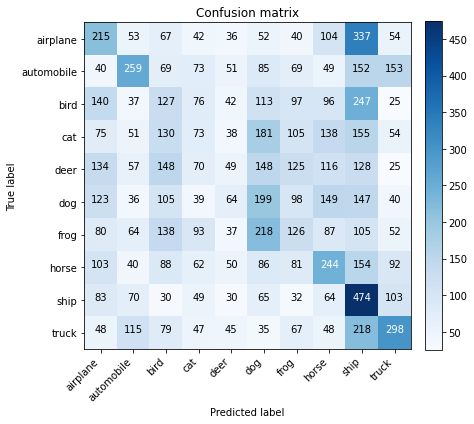

In [30]:
n_components = np.arange(100, 301, 50)
best_score = 0
best_n = 0
best_sgd = None
best_pca = None

for n in n_components:
    pca = PCA(n_components=n).fit(X1s)
    X1sp = pca.transform(X1s)
    X2sp = pca.transform(X2s)

    sgdn = SGDClassifier().fit(X1sp, y1)
    y2e = sgdn.predict(X2sp)

    score = sgdn.score(X2sp, y2)

    if score > best_score:
        best_score = score
        best_n = n
        best_sgd = sgdn
        best_pca = pca

print('Best n_components:', best_n)

sgdn = best_sgd
pca = best_pca

# pca = PCA(n_components=best_n).fit(X1s)
X1sp = pca.transform(X1s)
X2sp = pca.transform(X2s)

# sgdn = SGDClassifier().fit(X1sp, y1)
y2e = sgdn.predict(X2sp)

print('Score:', sgdn.score(X2sp, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


For some reason, the PCA with normalized data performed worse than the PCA without normalized data

## Conclusion

| Strategy | Score | Number of Errors | Precision | Recall | F1-Score |
| --- | --- | --- | --- | --- | --- |
| Multi-Class not Normalized Data | 20.47% | 7953 | 30.00% | 20.00% | 17.00% |
| Multi-Class Normalized Data | 20.03% | 7997 | 20.00% | 20.00% | 19.00% |
| Multi-Class Normalized Data with Validation | 21.07% | 7893 | 20.00% | 21.00% | 20.00% |
| PCA not Normalized Data | 22.50% | 7750 | 23.00% | 23.00% | 20.00% |
| PCA Normalized Data | 20.64% | 7936 | 20.00% | 21.00% | 20.00% |

With the data normalized, it's possible to see that, even with worse score, the confusion matrix is more distributed

Looking at the confusion matrices we can see a pattern that the classifiers can distinguish a little better the images between vehicles and animals


# Example preview

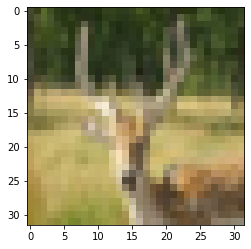

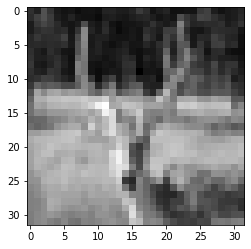

4


In [31]:
plot(Xtrain[0])
plot(XtrainG[0])
print(ytrain[0])
